<a href="https://colab.research.google.com/github/lorenzosintini/4YP/blob/master/Models_v2/Conv_VAE_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import Libraries

In [111]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys
from IPython.display import clear_output
import os
import pandas as pd
tf.autograph.set_verbosity(0)
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#### Import Data and plot it

In [0]:
def plot_images(x_train, y_train, figures_to_plot, pick_random=False, include_labels=True):
    n_rows = np.ceil((figures_to_plot[1])/10)
    plot = plt.figure(figsize=[20,2*n_rows])
    for i in range(figures_to_plot[0],figures_to_plot[1]):
        if pick_random: 
            pic_n = random.randint(0,len(x_train))
        else: pic_n = i
        plt.subplot(n_rows,10,i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(x_train[pic_n], cmap=plt.cm.binary)
        if include_labels:
            plt.xlabel(y_train[pic_n])
    plt.show()

#plot_images(x_train, y_train, [0,10])

#### Select data, pre-process it and create dataset

In [0]:
def pick_class(x, y, class_n):
    pics = (y == class_n[0])
    for i in range(len(class_n)-1):
      pics = pics + (y == class_n[i+1])
    new_x = x[pics]
    new_y = y[pics]
    return new_x, new_y

def set_pixels_binary(images):
    images = images/input_range
    #images[images >= 0.5] = 1.0
    #images[images < 0.5] = 0.0
    return images

def make_categorical(y):
    y_cat = tf.keras.utils.to_categorical(y)
    return y_cat

def cut_data(data, data_number):
    data = data[0:data_number]
    return data

def setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7,8,9], data_number = -1):
  x_train, y_train = pick_class(x_train, y_train, chosen_classes)
  x_test, y_test = pick_class(x_test, y_test, chosen_classes)
  
  x_train = cut_data(x_train, data_number)
  y_train = cut_data(y_train, data_number)

  train_images = set_pixels_binary(x_train)
  test_images = set_pixels_binary(x_test)

  train_images = train_images.reshape(len(y_train), image_shape[0], image_shape[1], N_image_channels).astype('float32')
  test_images = test_images.reshape(len(y_test), image_shape[0], image_shape[1], N_image_channels).astype('float32')

  batch_size = 100
  train_dataset = tf.data.Dataset.from_tensor_slices((train_images)).shuffle(len(y_train)).batch(batch_size)
  test_dataset = tf.data.Dataset.from_tensor_slices((test_images)).shuffle(len(y_test)).batch(batch_size)
  return x_train, y_train, x_test, y_test, train_dataset, test_dataset

#### Create Variational Autoencoder (VAE) Model

In [0]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.encoder_nn = tf.keras.models.Sequential([ 
                          tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
                          tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(z_size*2)
                          ])

        self.decoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Dense(units=24*24*64, activation='relu', input_shape=(z_size,)),
                          tf.keras.layers.Reshape(target_shape=(24, 24, 64)),
                          tf.keras.layers.Conv2DTranspose(32, (3,3), activation='relu'),
                          tf.keras.layers.Conv2DTranspose(1, (3,3)),
                          ])

    def encode(self, x):
        encoder_nn_output = self.encoder_nn(x)
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled
      

    def decode(self, z):
        pixel_output = self.decoder_nn(z)
        pixel_prob = tf.math.sigmoid(pixel_output)
        return pixel_prob

In [136]:
model.encoder_nn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
flatten_5 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                1843250   
Total params: 1,862,066
Trainable params: 1,862,066
Non-trainable params: 0
_________________________________________________________________


#### Define the loss function 

In [0]:
def calculate_ELBO(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    
    pixel_prob = model.decode(z)
    
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*x + tf.math.log(1-pixel_prob + 1e-10)*(1-x)
    logpx_z_images = tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    logpx_z = tf.reduce_mean (logpx_z_images)
    
    KL_parameters = -0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    KL = tf.reduce_mean(KL_vectors)
    
    ELBO = (logpx_z - KL)
    
    return -ELBO, logpx_z, KL #Negative because we want to maximise it

In [0]:
def calculate_pixel_squared(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_prob = model.decode(z)
    pixel_squared = np.square(pixel_prob - x)
    pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
    pixel_squared = tf.reduce_mean (pixel_squared)
    return pixel_squared

In [0]:
def calculate_ssim(model, x):
  z_mean, z_logvar = model.encode(x)
  z = model.reparameterize(z_mean, z_logvar)
  y = model.decode(z)

  x = tf.convert_to_tensor(x)
  y = tf.convert_to_tensor(y)
  ssim = tf.image.ssim(x[:,:,:,:],y[:,:,:,:], input_range, filter_size=11,filter_sigma=0.1,k1=0.1,k2=0.01)
  ssim = tf.reduce_mean(ssim)
  return (1-ssim)*1000

#### Define the optimizer

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0003)

#### Define loss metrics

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

#### Define train and test steps

In [0]:
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss,_,_ = calculate_ELBO(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x, optimizer):
    loss,_,_ = calculate_ELBO(model, x)
    test_loss(loss)

#### Generate random image from latent vector

In [0]:
def generate_images(model, z_random, figures_to_plot):
    generated_prob = model.decode(z_random)
    generated_prob = np.squeeze(generated_prob, axis=3)
    plot_images(generated_prob, _, figures_to_plot, include_labels=False)

In [0]:
def train_test_dataset(model, train_dataset, test_dataset, epochs, generate=True):
  plots_per_epoch = 10
  z_random = tf.random.normal(shape=[plots_per_epoch, z_size])
  
  test_ELBO = []
  train_ELBO = []
  epoch_number = []  
  for epoch in range(epochs):
    print('Epoch {}'.format(epoch))
    for train_x in train_dataset: 
      train_step(model, train_x, optimizer)
  
    for test_x in test_dataset:
      test_step(model, test_x, optimizer)
    
    test_ELBO.append(-test_loss.result())
    train_ELBO.append(-train_loss.result())
    epoch_number.append(epoch)
    
    clear_output()
    if generate:
      generate_images(model, z_random, [0,plots_per_epoch])
    plt.plot(epoch_number, test_ELBO, train_ELBO)
    plt.legend(['test','train'])
    plt.title('model')
    plt.show()
  train_loss.reset_states()
  test_loss.reset_states()

#### Train the data

In [0]:
def change_ratio(x, y, chosen_classes, chosen_numbers):
    x_new = np.zeros([0,image_shape[0], image_shape[1]])
    y_new = np.zeros([0])
    n_classes = len(chosen_classes)
    for i in range (n_classes):
        x_class, y_class = pick_class(x, y, [chosen_classes[i]])
        x_class = cut_data(x_class, chosen_numbers[i])
        y_class = cut_data(y_class, chosen_numbers[i])
        x_new = np.concatenate((x_new, x_class))
        y_new = np.concatenate((y_new, y_class))
    return x_new, y_new

In [0]:
mnist = tf.keras.datasets.mnist
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

class_names = ['Zero','One', 'Two', 'Three', 'Four', 'Five','Six', 'Seven', 'Eight', 'Nine']
N_image_channels = 1
N_class = len(class_names)
image_shape = x_train.shape[1:3]
input_range = np.amax(x_train)

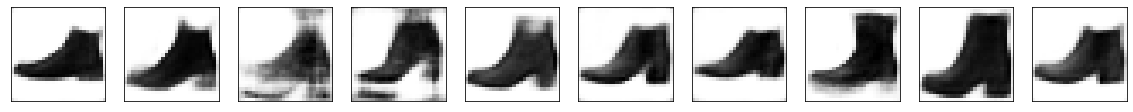

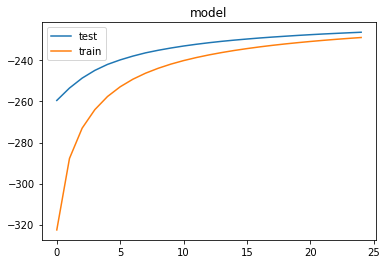

In [15]:
chosen_classes=[0,1,2,3,4,5,6,7,8,9]
chosen_numbers = [5, 10, 50, 100, 500, 1000, 2000, 3000, 4500, 6000]
x_train, y_train = change_ratio(x_train, y_train, chosen_classes, chosen_numbers)
chosen_numbers = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
x_test, y_test = change_ratio(x_test, y_test, chosen_classes, chosen_numbers)

x_train_0, y_train_0, x_test_0, y_test_0, train_dataset_0, test_dataset_0 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0])
x_train_1, y_train_1, x_test_1, y_test_1, train_dataset_1, test_dataset_1 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[1])
x_train_2, y_train_2, x_test_2, y_test_2, train_dataset_2, test_dataset_2 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[2])
x_train_3, y_train_3, x_test_3, y_test_3, train_dataset_3, test_dataset_3 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[3])
x_train_4, y_train_4, x_test_4, y_test_4, train_dataset_4, test_dataset_4 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[4])
x_train_5, y_train_5, x_test_5, y_test_5, train_dataset_5, test_dataset_5 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[5])
x_train_6, y_train_6, x_test_6, y_test_6, train_dataset_6, test_dataset_6 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[6])
x_train_7, y_train_7, x_test_7, y_test_7, train_dataset_7, test_dataset_7 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[7])
x_train_8, y_train_8, x_test_8, y_test_8, train_dataset_8, test_dataset_8 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[8])
x_train_9, y_train_9, x_test_9, y_test_9, train_dataset_9, test_dataset_9 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[9])

z_size = 25
model_0 = CVAE(z_size)
model_1 = CVAE(z_size)
model_2 = CVAE(z_size)
model_3 = CVAE(z_size)
model_4 = CVAE(z_size)
model_5 = CVAE(z_size)
model_6 = CVAE(z_size)
model_7 = CVAE(z_size)
model_8 = CVAE(z_size)
model_9 = CVAE(z_size)

model_dict = {'0' : model_0,
              '1' : model_1,
		          '2' : model_2,
              '3' : model_3,
              '4' : model_4,
              '5' : model_5,
              '6' : model_6,
              '7' : model_7,
              '8' : model_8,
              '9' : model_9,}

train_test_dataset(model_0, train_dataset_0, test_dataset_0, 25, generate=True)
train_test_dataset(model_1, train_dataset_1, test_dataset_1, 25, generate=True)
train_test_dataset(model_2, train_dataset_2, test_dataset_2, 25, generate=True)
train_test_dataset(model_3, train_dataset_3, test_dataset_3, 25, generate=True)
train_test_dataset(model_4, train_dataset_4, test_dataset_4, 25, generate=True)
train_test_dataset(model_5, train_dataset_5, test_dataset_5, 25, generate=True)
train_test_dataset(model_6, train_dataset_6, test_dataset_6, 25, generate=True)
train_test_dataset(model_7, train_dataset_7, test_dataset_7, 25, generate=True)
train_test_dataset(model_8, train_dataset_8, test_dataset_8, 25, generate=True)
train_test_dataset(model_9, train_dataset_9, test_dataset_9, 25, generate=True)

#### Reconstruct images

Original Pictures:


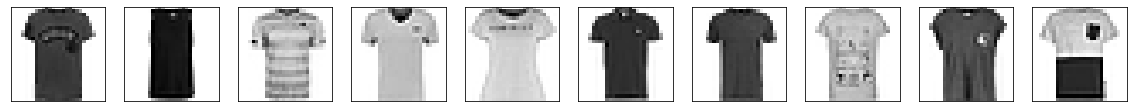

Reconstructed Pictures, with ELBO loss:


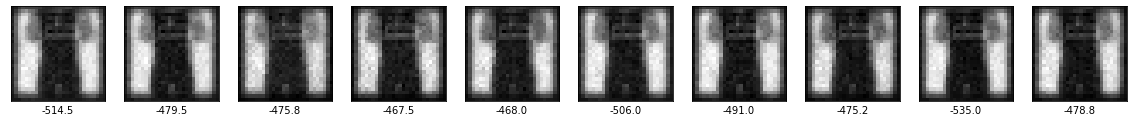

In [16]:
def reconstruct_images(model, images):
    images_n = len(images)
    x = images/input_range
    #x[x >= 0.5] = 1.0
    #x[x < 0.5] = 0.0
    x = x.reshape(images_n, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_output = model.decode(z)
    pixel_prob = tf.math.sigmoid(pixel_output)
    pixel_prob = np.squeeze(pixel_prob, axis=3)

    loss = np.empty([images_n])
    for i in range(images_n):
        loss[i],_,_ = calculate_ELBO(model,x[i:i+1])
    loss = loss.astype('float16')
    
    print('Original Pictures:')
    plot_images(images, _, figures_to_plot=[0,images_n], include_labels=False)
    print('Reconstructed Pictures, with ELBO loss:')
    plot_images(pixel_prob, -loss, figures_to_plot=[0,images_n], include_labels=True)

reconstruct_images(model_0, x_test_0[0:10])

#### Visualize the latent space

79 Outliers detected


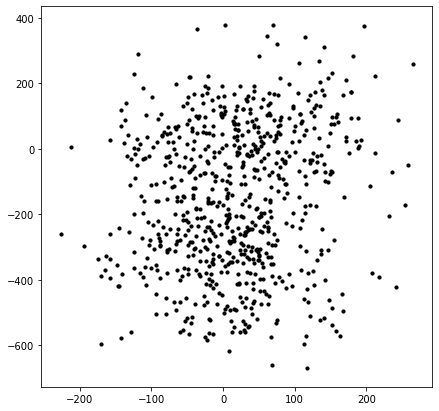

In [71]:
def visualize_latent_space(model, range1, range2, data_x, data_y, a, b):
  plot = plt.figure(figsize=[7,7])
  outliers=0
  for i in range(range1, range2):
    pic_visualize = data_x[i]
    pic_visualize = pic_visualize.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    
    z_mean, z_logvar = model.encode(pic_visualize)
    z = model.reparameterize(z_mean, z_logvar)
    
    if any(z_logvar[:,i]>5 for i in range(z_size)):
      outliers +=1
      continue
      
    if data_y[i] == 0:
      color = 'blue'
    if data_y[i] == 1:
      color = 'orange'
    if data_y[i] == 2:
      color = 'green'
    if data_y[i] == 3:
      color = 'red'
    if data_y[i] == 4:
      color = 'purple'  
    if data_y[i] == 5:
      color = 'brown'
    if data_y[i] == 6:
      color = 'pink'
    if data_y[i] == 7:
      color = 'gray'
    if data_y[i] == 8:
      color = 'black'
    if data_y[i] == 9:
      color = 'yellow'
    plt.scatter(z[:,a],z[:,b], color=color, s=10)
    #plt.xlim([-1000,1000])
    #plt.ylim([-1000,1000])
    #plt.annotate('{}'.format(i),(z[:,a],z[:,b]))
  print('{} Outliers detected'.format(outliers))


visualize_latent_space(model_8, 0,800, x_test_8, y_test_8, 0,1)

#labels = []; 
#for i in range(N_train): labels.append(i)
#plot_images(x_train, labels, [250,300])

#### Check reconstruction performance for untrained classes


Model trained with class 0


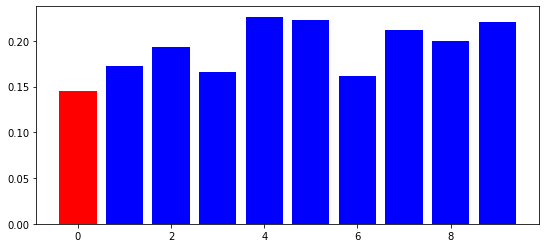

Model trained with class 1


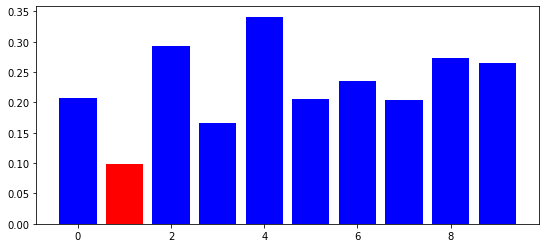

Model trained with class 2


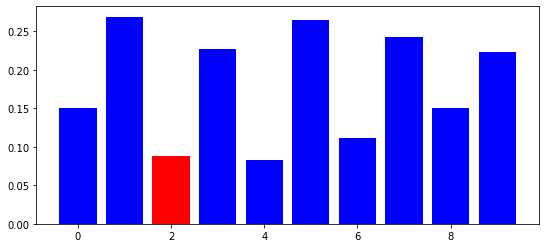

Model trained with class 3


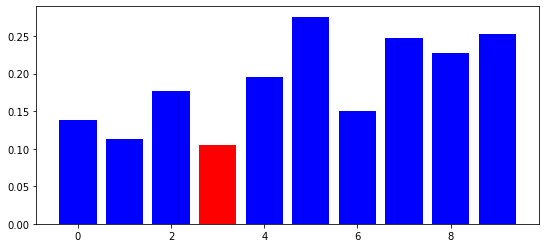

Model trained with class 4


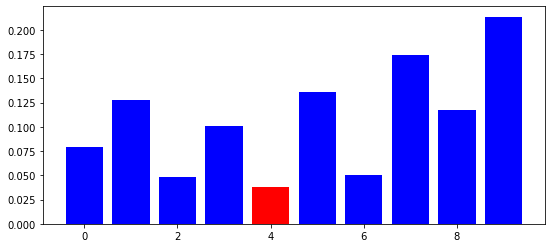

Model trained with class 5


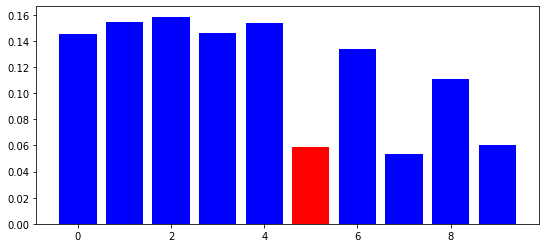

Model trained with class 6


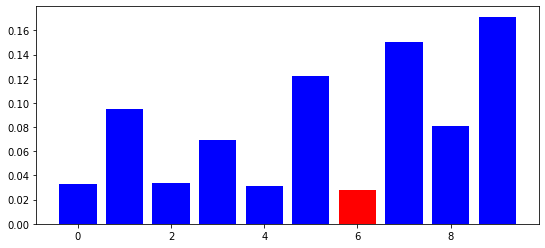

Model trained with class 7


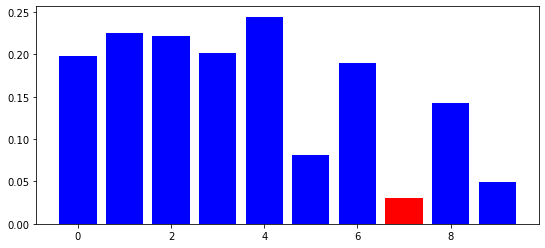

Model trained with class 8


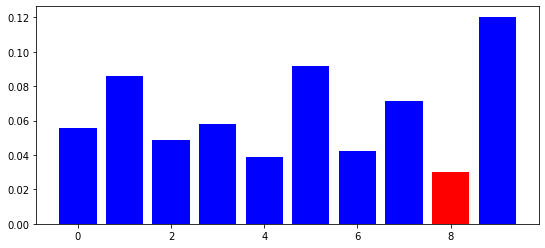

Model trained with class 9


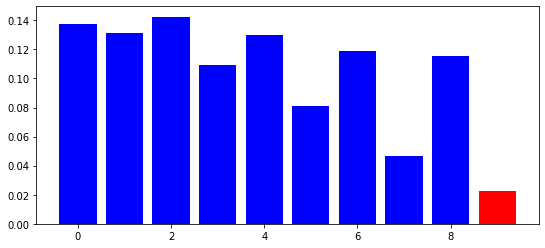

In [18]:
table_of_losses = np.zeros([N_class, N_class])
for i in range(0,N_class):
  model = model_dict[str(i)]
  print('Model trained with class {}'.format(i))
  plt.figure(figsize=[9,4])
  for j in range(N_class):
    test_images = x_test[(y_test==j)]
    test_images = set_pixels_binary(test_images)
    test_images = test_images.reshape(len(test_images), image_shape[0], image_shape[1], N_image_channels).astype('float32')
    #_,loss,_ = calculate_ELBO(model,test_images)
    #loss = -calculate_pixel_squared(model,test_images)
    loss = calculate_ssim(model, test_images)
    table_of_losses[j,i] = loss
    if j==i:
      color='red'
    else:
      color='blue'
    plt.bar(j,loss.numpy(),color=color)
    #print('ELBO loss for class {}: {}'.format(i,loss))
  plt.show()

for i in range(N_class):
    table_of_losses[i,:] = table_of_losses[i,:]/np.min(table_of_losses[i,:])
  

# reconstruct_images(x_test[(y_test==8)][0:10], test_images[(y_test==8)][0:10])

#visualize_latent_space(0,1000, x_train, y_train, 0,1)
#classes_to_pick = [1]
#x_reconstruct_test, y_reconstruct_test = pick_class(x_test, y_test, classes_to_pick)
#visualize_latent_space(0,100, x_reconstruct_test, y_reconstruct_test, 0,1)


#### Classify test images

In [109]:
#_, _, x_test_classes, y_test_classes, _, _ = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7,8,9])
chosen_numbers = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
x_test_classes, y_test_classes = change_ratio(x_test, y_test, chosen_classes, chosen_numbers)
predicted_class = np.zeros([1,len(x_test_classes)])
predicted_probabilities = np.zeros([len(x_test_classes),10])
for i in range(len(x_test_classes)):
  if not i%10:
    clear_output()
    print('Progress:{}%'.format(100*(i+1)/len(x_test_classes)))
  test_image = x_test_classes[i]/input_range
  #test_image[test_image >= 0.5] = 1.0
  #test_image[test_image < 0.5] = 0.0
  test_image = test_image.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
  
  loss_per_model = np.empty([1,10])
  a = np.empty([1,10])
  for j in range(0,10):
    model = model_dict[str(j)]
    loss1,_,_ = calculate_ELBO(model,test_image)
    #loss2 = calculate_ssim(model,test_image)
    #print('ELBO loss for class {}: {}'.format(i,loss))
    loss_per_model[0,j]= -loss1
    #loss_per_model[1,j] = loss2
  a[0,:] = loss_per_model[0,:]/np.min(loss_per_model[0,:])
  #a[1,:] = loss_per_model[1,:]/np.min(loss_per_model[1,:])
  a = np.multiply(a,-2)
  e_x = np.exp(a)
  predicted_probabilities[i,:] = (e_x[0,:] / e_x[0,:].sum())*100
  #predicted_probabilities[2*i+1,:] = (e_x[1,:] / e_x[1,:].sum())*100
  max_index = np.argmax(predicted_probabilities[i,:])
  predicted_class[0,i] = max_index%10
  #predicted_class[0,i] = loss_per_model.index(min(loss_per_model))
  print(predicted_class[0,i])
print(predicted_class)

Progress:0.31%
6.0
6.0


KeyboardInterrupt: ignored

#### Check accuracy and plot misslabeled images

In [0]:
import pandas as pd
predicted_class = predicted_class.astype('int')
y_test_classes = y_test_classes.astype('int')

wrong_guesses = []
table_of_counts = np.zeros([N_class+1, N_class+1])
for i in range(predicted_class.shape[1]):
    table_of_counts[y_test_classes[i], predicted_class[0,i]]+=1
    if y_test_classes[i] != predicted_class[0,i]:
        wrong_guesses.append(i)
trace_count = table_of_counts.trace().astype('int')
sum_count = table_of_counts.sum().astype('int')
for i in range(N_class):
    accuracy_of_class = 100*table_of_counts[i,i]/np.sum(table_of_counts[i,0:-1])
    table_of_counts[i,-1] = accuracy_of_class.astype('float16')
for i in range(N_class):
  table_of_counts[-1,i] = np.sum(table_of_counts[0:10,i])-table_of_counts[i,i]

index = list(str('-') * (N_class+1))
columns = list(str('-') * (N_class+1))
for i in range(N_class):
    index[i]= 'Class '+ str(i)
    columns[i] = '|' + str(i) + '_Counts|'
index[-1] = 'False Positives'
columns[-1] = 'Percentage'
table = pd.DataFrame.from_records(table_of_counts, index=index, columns=columns)

probabilities = np.zeros([len(wrong_guesses)])
pics_to_plot = list(x_test[i] for i in wrong_guesses)
labels = list(predicted_class[0,i] for i in wrong_guesses)
for i in range(len(wrong_guesses)):
    probabilities[i] = predicted_probabilities[wrong_guesses[i],labels[i]]
    probabilities = probabilities

#plot_images(pics_to_plot[0:10], probabilities[0:10], [0,len(labels[0:50])])

all_probabilities = np.zeros([len(x_test_classes)])
for i in range(len(x_test_classes)):
    all_probabilities[i] = predicted_probabilities[i,predicted_class[0,i]]
    all_probabilities = all_probabilities#

#plot_images(x_test_classes[0:50], all_probabilities[0:50], [0,len(labels[0:50])])

In [108]:
print('Correctly labelled pictures:{}/{} -> Accuracy: {}%'.format(trace_count, sum_count, trace_count/sum_count*100))
print('Incorrectly labelled pictures:{}/{} -> Error: {}%'.format(sum_count-trace_count, sum_count, (sum_count-trace_count)/sum_count*100))
table

Correctly labelled pictures:957/10000 -> Accuracy: 9.569999999999999%
Incorrectly labelled pictures:9043/10000 -> Error: 90.42999999999999%


,|0_Counts|,|1_Counts|,|2_Counts|,|3_Counts|,|4_Counts|,|5_Counts|,|6_Counts|,|7_Counts|,|8_Counts|,|9_Counts|,Percentage
Class 0,957.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,1.0,0.0,95.6875
Class 1,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
Class 2,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
Class 3,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
Class 4,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
Class 5,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
Class 6,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
Class 7,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
Class 8,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
Class 9,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000


In [0]:
# Convolutional VAE for each class results in accuracy of 98.16% with z_size = 10
# Convolutional VAE for each class results in accuracy of 89.90% with z_size = 2

In [31]:
index = list(str('-') * N_class)
columns = list(str('-') * (N_class))
for i in range(N_class):
    index[i]= 'Class '+ str(i)
    columns[i] = 'Model ' + str(i)

table_loss = pd.DataFrame.from_records(np.around(table_of_losses, decimals=2), index=index, columns=columns)
table_loss

,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8,Model 9
Class 0,4.36,6.25,4.52,4.15,2.39,4.37,1.00,5.94,1.67,4.13
Class 1,2.01,1.16,3.14,1.32,1.49,1.80,1.10,2.63,1.00,1.53
Class 2,5.71,8.65,2.59,5.22,1.42,4.69,1.00,6.56,1.45,4.22
Class 3,2.85,2.86,3.91,1.80,1.74,2.50,1.20,3.46,1.00,1.87
Class 4,7.31,11.03,2.68,6.30,1.24,4.96,1.00,7.90,1.26,4.19
Class 5,3.79,3.50,4.52,4.69,2.31,1.00,2.08,1.39,1.56,1.38
Class 6,5.76,8.43,3.97,5.38,1.78,4.77,1.00,6.76,1.51,4.24
Class 7,7.04,6.81,8.09,8.21,5.79,1.77,5.00,1.00,2.38,1.56
Class 8,6.69,9.16,5.01,7.61,3.92,3.71,2.70,4.78,1.00,3.86
Class 9,9.65,11.60,9.78,11.04,9.36,2.65,7.51,2.16,5.27,1.00


In [0]:
y_true = np.zeros([10,len(y_test_classes)])
for i in range(len(y_test_classes)):
    y_true[y_test_classes[i].astype('int'),i]=1

y_score = np.zeros([10,len(y_test_classes)])
for i in range(len(y_test_classes)):
    y_score[:,i] = predicted_probabilities[i]

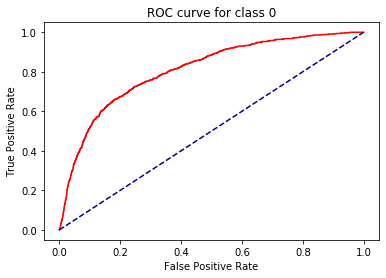

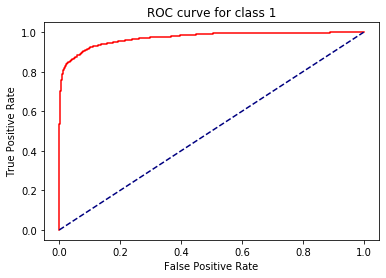

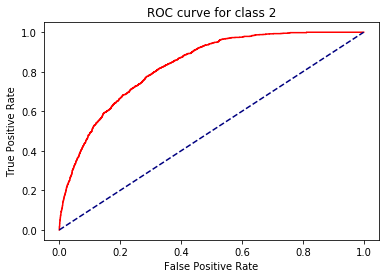

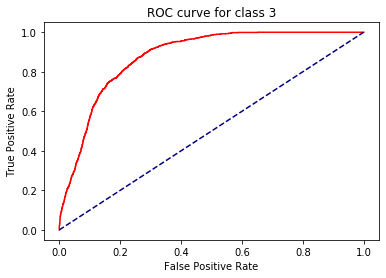

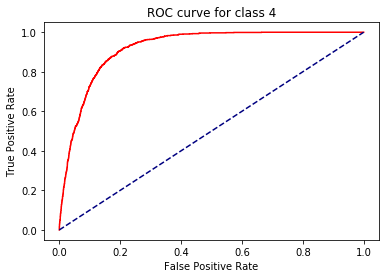

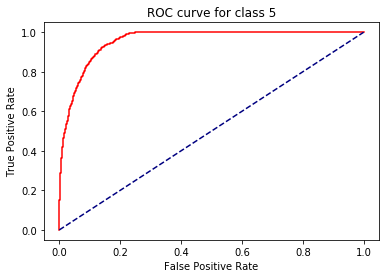

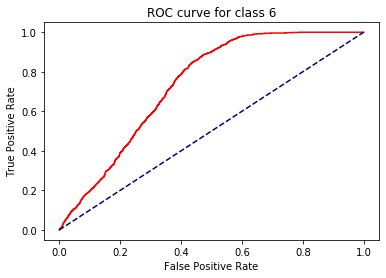

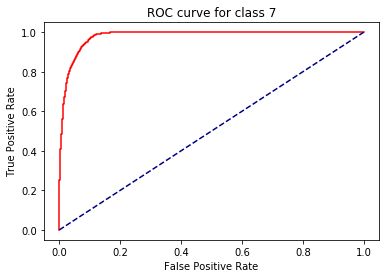

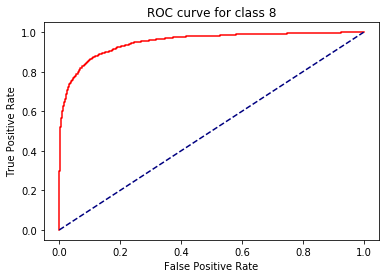

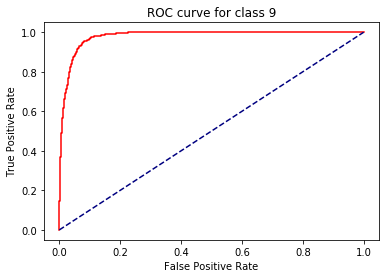

In [38]:
from sklearn.metrics import roc_curve
plot = plt.figure()
for i in range(10):
  fpr, tpr, _ = roc_curve(y_true[i,:], y_score[i,:])
  plt.plot(fpr, tpr, color='red')
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve for class '+str(i))
  plt.show()

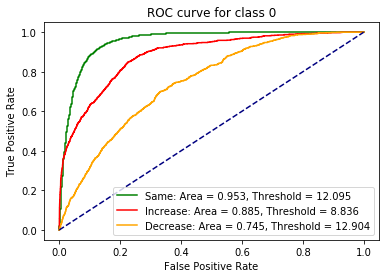

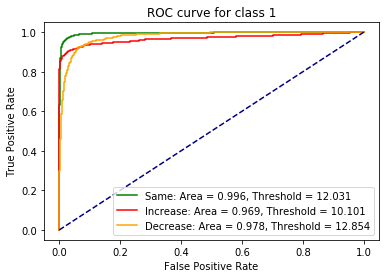

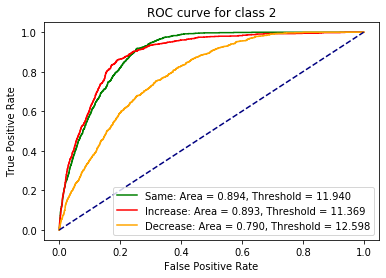

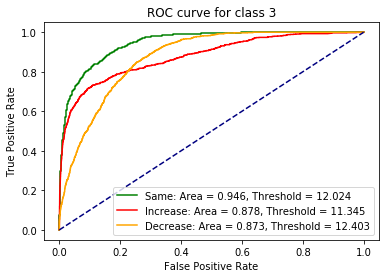

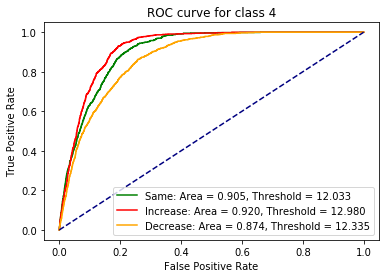

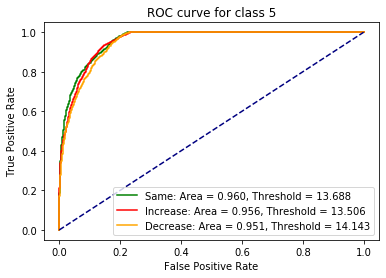

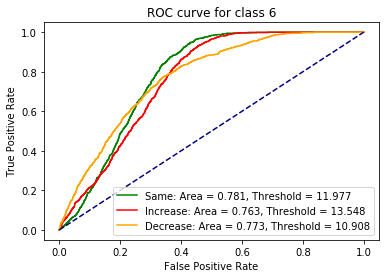

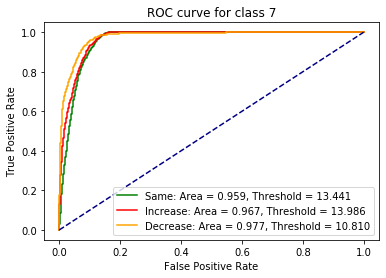

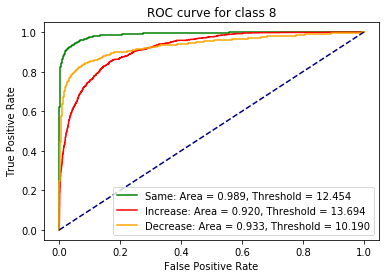

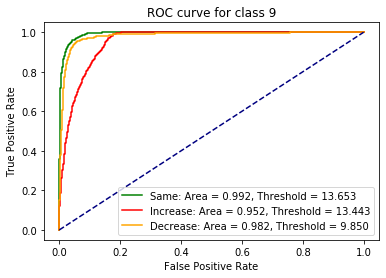

In [276]:
_, _, x_test_classes, y_test_classes, _, _ = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7,8,9])
chosen_numbers = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
x_test_classes, y_test_classes = change_ratio(x_test, y_test, chosen_classes, chosen_numbers)

prob_same = np.zeros([np.sum(chosen_numbers),10])
for i in range(10):
  if i==0:
    prob_same[0:chosen_numbers[i]]=(predicted_prob_same[1000*i:1000*i+chosen_numbers[i]])
  if i!=0:
    prob_same[np.sum(chosen_numbers[:i]).astype('int'):np.sum(chosen_numbers[:i]).astype('int')+chosen_numbers[i]]=(predicted_prob_same[1000*i:1000*i+chosen_numbers[i]])

prob_increase = np.zeros([np.sum(chosen_numbers),10])
for i in range(10):
  if i==0:
    prob_increase[0:chosen_numbers[i]]=(predicted_prob_increase[1000*i:1000*i+chosen_numbers[i]])
  if i!=0:
    prob_increase[np.sum(chosen_numbers[:i]).astype('int'):np.sum(chosen_numbers[:i]).astype('int')+chosen_numbers[i]]=(predicted_prob_increase[1000*i:1000*i+chosen_numbers[i]])

prob_decrease = np.zeros([np.sum(chosen_numbers),10])
for i in range(10):
  if i==0:
    prob_decrease[0:chosen_numbers[i]]=(predicted_prob_decrease[1000*i:1000*i+chosen_numbers[i]])
  if i!=0:
    prob_decrease[np.sum(chosen_numbers[:i]).astype('int'):np.sum(chosen_numbers[:i]).astype('int')+chosen_numbers[i]]=(predicted_prob_decrease[1000*i:1000*i+chosen_numbers[i]])


y_true = np.zeros([10,len(y_test_classes)])
for i in range(len(y_test_classes)):
    y_true[y_test_classes[i].astype('int'),i]=1

y_score_same = np.zeros([10,len(y_test_classes)])
for i in range(len(y_test_classes)):
    y_score_same[:,i] = prob_same[i]

y_score_increase = np.zeros([10,len(y_test_classes)])
for i in range(len(y_test_classes)):
    y_score_increase[:,i] = prob_increase[i]

y_score_decrease = np.zeros([10,len(y_test_classes)])
for i in range(len(y_test_classes)):
    y_score_decrease[:,i] = prob_decrease[i]

from sklearn.metrics import roc_curve, auc
plot = plt.figure()
for i in range(10):
  fpr_same, tpr_same, threshold_same = roc_curve(y_true[i,:], y_score_same[i,:])
  auc_same = auc(fpr_same, tpr_same)
  fpr_increase, tpr_increase, threshold_increase = roc_curve(y_true[i,:], y_score_increase[i,:])
  auc_increase = auc(fpr_increase, tpr_increase)
  fpr_decrease, tpr_decrease, threshold_decrease = roc_curve(y_true[i,:], y_score_decrease[i,:])
  auc_decrease = auc(fpr_decrease, tpr_decrease)

  optimal_idx_same = np.argmin(np.sqrt(np.square(1-tpr_same) + np.square(fpr_same)))
  optimal_threshold_same = threshold_same[optimal_idx_same]
  optimal_idx_increase = np.argmin(np.sqrt(np.square(1-tpr_increase) + np.square(fpr_increase)))
  optimal_threshold_increase = threshold_increase[optimal_idx_increase]
  optimal_idx_decrease = np.argmin(np.sqrt(np.square(1-tpr_decrease) + np.square(fpr_decrease)))
  optimal_threshold_decrease = threshold_decrease[optimal_idx_decrease]

  plt.plot(fpr_same, tpr_same, color='green', label='Same: Area = %0.3f, Threshold = %0.3f' % (auc_same, optimal_threshold_same))
  plt.plot(fpr_increase, tpr_increase, color='red', label='Increase: Area = %0.3f, Threshold = %0.3f' % (auc_increase, optimal_threshold_increase))
  plt.plot(fpr_decrease, tpr_decrease, color='orange', label='Decrease: Area = %0.3f, Threshold = %0.3f' % (auc_decrease, optimal_threshold_decrease))
  
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve for class '+str(i))
  plt.legend(loc="lower right")
  plt.show()

In [291]:
optimal_threshold_increase = [8.604, 12.693, 10.993, 10.605, 12.829, 14.027, 13.215, 14.143, 13.648, 13.770]
predictions = np.zeros([len(y_test_classes),10])
for i in range(len(y_test_classes)):
  a = np.arange(10)
  np.random.shuffle(a)
  #for j in a:
  #  if prob_increase[i,j] > (optimal_threshold_increase[j])*0.93:
  #    predictions[i,j] = 1
  #    break
  diff = prob_increase[i,:]-np.multiply(optimal_threshold_increase,1)
  #predictions[i,np.argmax(prob_increase[i,:])]=1
  predictions[i,np.argmax(diff)]=1

count_0=[]; count_1=[]; count_2=[]; count_3=[]; count_4=[]; count_5=[]; count_6=[]

for i in range(len(predictions)):
  if np.sum(predictions[i,:])==0: count_0.append(i)
  if np.sum(predictions[i,:])==1: count_1.append(i)
  if np.sum(predictions[i,:])==2: count_2.append(i)
  if np.sum(predictions[i,:])==3: count_3.append(i)
  if np.sum(predictions[i,:])==4: count_4.append(i)
  if np.sum(predictions[i,:])==5: count_5.append(i)
  if np.sum(predictions[i,:])==6: count_6.append(i)

print(len(count_0))
print(len(count_1))
print(len(count_2))
print(len(count_3))
print(len(count_4))
print(len(count_5))
print(len(count_6))
print(len(count_0)+len(count_1)+len(count_2)+len(count_3)+len(count_4)+len(count_5)+len(count_6))
#print(prob_increase[:5])

0
10000
0
0
0
0
0
10000


In [292]:
import pandas as pd
#print(np.shape(predictions))
y_test_classes = y_test_classes.astype('int')
predictions = np.argmax(predictions, axis=1)
#print(np.shape(predictions))
predictions = predictions.astype('int')

wrong_guesses = []
table_of_counts = np.zeros([N_class+1, N_class+1])
for i in range(len(predictions)):
    table_of_counts[y_test_classes[i], predictions[i]]+=1
    if y_test_classes[i] != predictions[i]:
        wrong_guesses.append(i)
trace_count = table_of_counts.trace().astype('int')
sum_count = table_of_counts.sum().astype('int')
for i in range(N_class):
    accuracy_of_class = 100*table_of_counts[i,i]/np.sum(table_of_counts[i,0:-1])
    table_of_counts[i,-1] = accuracy_of_class.astype('float16')
for i in range(N_class):
  table_of_counts[-1,i] = np.sum(table_of_counts[0:10,i])-table_of_counts[i,i]

index = list(str('-') * (N_class+1))
columns = list(str('-') * (N_class+1))
for i in range(N_class):
    index[i]= 'Class '+ str(i)
    columns[i] = '|' + str(i) + '_Counts|'
index[-1] = 'False Positives'
columns[-1] = 'Percentage'
trace_count = table_of_counts.trace().astype('int')
sum_count = table_of_counts[0:-1,0:-1].sum().astype('int')
table = pd.DataFrame.from_records(table_of_counts, index=index, columns=columns)

probabilities = np.zeros([len(wrong_guesses)])
pics_to_plot = list(x_test[i] for i in wrong_guesses)
labels = list(predictions[i] for i in wrong_guesses)
for i in range(len(wrong_guesses)):
    probabilities[i] = predicted_probabilities[wrong_guesses[i],labels[i]]
    probabilities = probabilities
#print('Correctly labelled pictures:{}/{} -> Accuracy: {}%'.format(trace_count, sum_count, trace_count/sum_count*100))
#print('Incorrectly labelled pictures:{}/{} -> Error: {}%'.format(sum_count-trace_count, sum_count, (sum_count-trace_count)/sum_count*100))
print(np.sum(table['Percentage'])/10)
table

61.615625


,|0_Counts|,|1_Counts|,|2_Counts|,|3_Counts|,|4_Counts|,|5_Counts|,|6_Counts|,|7_Counts|,|8_Counts|,|9_Counts|,Percentage
Class 0,750.0,0.0,38.0,34.0,0.0,0.0,174.0,0.0,4.0,0.0,75.00000
Class 1,509.0,352.0,16.0,104.0,2.0,0.0,15.0,0.0,2.0,0.0,35.18750
Class 2,26.0,0.0,720.0,30.0,60.0,0.0,164.0,0.0,0.0,0.0,72.00000
Class 3,380.0,0.0,22.0,517.0,6.0,0.0,69.0,0.0,6.0,0.0,51.68750
Class 4,16.0,0.0,564.0,123.0,195.0,0.0,101.0,0.0,1.0,0.0,19.50000
Class 5,11.0,0.0,9.0,1.0,0.0,780.0,1.0,86.0,11.0,101.0,78.00000
Class 6,215.0,0.0,434.0,45.0,17.0,0.0,281.0,0.0,8.0,0.0,28.09375
Class 7,3.0,0.0,0.0,0.0,0.0,10.0,0.0,789.0,4.0,194.0,78.87500
Class 8,19.0,0.0,110.0,56.0,0.0,0.0,10.0,0.0,803.0,2.0,80.31250
Class 9,7.0,0.0,5.0,3.0,0.0,0.0,0.0,9.0,1.0,975.0,97.50000


In [128]:
print(np.sum(table_increase['Percentage'])/10)
table_increase

58.60467529296875


,Unnamed: 0,|0_Counts|,|1_Counts|,|2_Counts|,|3_Counts|,|4_Counts|,|5_Counts|,|6_Counts|,|7_Counts|,|8_Counts|,|9_Counts|,Percentage
0,Class 0,4.0,0.0,0.0,2.0,0.0,0.0,971.0,0.0,23.0,0.0,0.399902
1,Class 1,4.0,711.0,0.0,24.0,3.0,0.0,217.0,0.0,41.0,0.0,71.125000
2,Class 2,0.0,0.0,1.0,0.0,83.0,0.0,894.0,0.0,22.0,0.0,0.099976
3,Class 3,10.0,0.0,0.0,261.0,47.0,0.0,617.0,0.0,64.0,1.0,26.093750
4,Class 4,0.0,0.0,0.0,1.0,237.0,0.0,748.0,0.0,14.0,0.0,23.703125
5,Class 5,0.0,0.0,0.0,0.0,0.0,806.0,0.0,124.0,4.0,66.0,80.625000
6,Class 6,1.0,0.0,0.0,2.0,11.0,0.0,956.0,0.0,30.0,0.0,95.625000
7,Class 7,0.0,0.0,0.0,0.0,0.0,8.0,0.0,930.0,0.0,62.0,93.000000
8,Class 8,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2.0,984.0,2.0,98.375000
9,Class 9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,28.0,1.0,970.0,97.000000


In [0]:
import pandas as pd
table_same = pd.read_csv('/content/drive/My Drive/4YP/table_same.csv')
table_increase = pd.read_csv('/content/drive/My Drive/4YP/table_increase.csv')
table_decrease = pd.read_csv('/content/drive/My Drive/4YP/table_decrease.csv')
table_loss_same = pd.read_csv('/content/drive/My Drive/4YP/table_loss_same.csv')
table_loss_increase = pd.read_csv('/content/drive/My Drive/4YP/table_loss_increase.csv')
table_loss_decrease = pd.read_csv('/content/drive/My Drive/4YP/table_loss_decrease.csv')
predicted_prob_same = np.load('/content/drive/My Drive/4YP/predicted_prob_same.npy')
predicted_prob_increase = np.load('/content/drive/My Drive/4YP/predicted_prob_increase.npy')
predicted_prob_decrease = np.load('/content/drive/My Drive/4YP/predicted_prob_decrease.npy')

In [42]:
predicted_prob_increase[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [144]:
a = [[0,1,2,3,4,5],[0,1,2,3,4,5],[0,1,2,3,4,5],[0,1,2,3,4,5],[0,1,2,3,4,5]]
#print(predicted_prob_increase[0:5].shape)
a=predicted_prob_increase
print(np.shape(a))
a[0:5] = [1,2,3,4,5,6,7,8,9,10]
print(np.shape(a))

(5, 10)
(10000, 10)
(10000, 10)


In [159]:
predicted_prob_increase[0]

array([12.74097725,  6.67545536, 10.59448253, 10.63937628, 11.98127069,
        7.14793303, 14.88482919,  3.86299686, 12.2927974 ,  9.17988141])